# FizzBuzz in Qiskit

Given a binary string $$c_5c_4c_3c_2c_1c_0$$ where two most significant bits $c_5c_4$ keep some information about a number encoded in four least significant bits $c_3c_2c_1c_0$. To acquire the string or rather a string list we measure in Pauli $Z$ basis some quantum register $$\lvert q_5q_4q_3q_2q_1q_0\rangle.$$

Any computation here is a quantum circuit, i.e. a sequence of unitaries apply on qubits for state evolution before measurements collapse a state to a string. Because the final part is probabilistic we run a  circuit on real device or simulator many times in a row. A result is a dictionary with binary strings are the keys and count outcomes are the values. Here it is required only 6 qubits not split into main and ancilla registers in a code but they can be mentioned this way in description.

## Imports

All required functions such as Grover Oracle, Quantum Fourier Transform, etc., are defined below and it is enough to import some standard Qiskit modules and last but not least numpy to get the $\pi$ value.

In [1]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
import numpy as np

## Initialization

First of all we apply Hadamard gate on whole main register creating a uniform superposition over all states. Now we are allowed to test the numbers in parallel.

In [2]:
def init(qc):
    qc.h(range(4))
    qc.barrier()

## Quantum Fourier Transform

Quantum Fourier Transform (QFT) is a number one subroutine in quantum computing. This way we perform a change of basis for some state turning its representation from bit to phase. Note that QFT defined here switches a qubit ordering so that MSB becomes LSB and vice versa. It can be fixed using extra $SWAP$ gates but we just reckon with it in computations. QFT is applied only on ancilla register.

In [3]:
def qft(qc):
    qc.h(5)
    qc.cp(np.pi/2, 4, 5)
    qc.h(4)
    qc.barrier()

## Divisibility by 3

We have $3_{10}=11_2$ and it is very easy to check if a binary number satisfies the condition. Same as for $11$ in decimal the algorithm takes an alternating digit sum. In other word we find the sums of its even and odd digits and compare them to each other. If they are equal or their difference is multiple of $11_2$ then the binary number is divisible by $11_2$. A maximum absolute difference in a four bit register equals to $10_2$ thus the second statement is always false and the divisibility test reduces to $$c_3-c_2+c_1-c_0\equiv0.$$

It is not applicable for large registers where a non-zero alternating digit sum may occur for multiples of $3$ too. Then either an oracle should consider that or the sum itself should be tested the same way again. The latter is much easier but it requires additional qubits for intermediate calculations.

The left-hand side can be done in two ways: a bit adder with $CX$ and $CCX$ gates or a phase adder with $CP$ gates. We choose the second one combines addition and substraction as an algebraic sum. It performs counterclockwise and clockwise phase rotations of ancilla qubits depend on sign.

In [4]:
def div_by_3(qc):
    qc.cp(np.pi/2, 3, 5)
    qc.cz(3, 4)
    qc.cp(-np.pi/2, 2, 5)
    qc.cz(2, 4)
    qc.cp(np.pi/2, 1, 5)
    qc.cz(1, 4)
    qc.cp(-np.pi/2, 0, 5)
    qc.cz(0, 4)
    qc.barrier()

For amplitude amplification to work correct it is required to set ancilla register to $\lvert00\rangle$ before diffusion. The stage is called 'uncomputation'. That is why we create a function inverse to above one. In phase addition it means all rotations just reverse their directions. Note that $CP(\pi)=CP(-\pi)=CZ$ so the gate remains unchanged.

In [5]:
def inv_div_by_3(qc):
    qc.cp(-np.pi/2, 3, 5)
    qc.cz(3, 4)
    qc.cp(np.pi/2, 2, 5)
    qc.cz(2, 4)
    qc.cp(-np.pi/2, 1, 5)
    qc.cz(1, 4)
    qc.cp(np.pi/2, 0, 5)
    qc.cz(0, 4)
    qc.barrier()

## Divisibility by 5

It seems a bit harder but very similar to the previous one. Now we have $3_{10}=11_4$ and each quaternary digit turns to a binary pair $11_4={0101}_2$ thus we compare the sums of even and odd pairs of digits. Just like before if they are equal or their difference is multiple of $0101_2$ then the binary number is divisible by $0101_2$. In four bit register there are only two pairs, the odd and the even, so we go straight to substraction skipping any addition. In this case a maximum absolute value of the difference could equal to $11_2$. The second statement is always false again and the divisibility test reduces to $$c_3c_2-c_1c_0\equiv0.$$

In [6]:
def div_by_5(qc):
    qc.cp(np.pi/2, 2, 5)
    qc.cz(2, 4)
    qc.cz(3, 5)
    qc.cp(-np.pi/2, 0, 5)
    qc.cz(0, 4)
    qc.cz(1, 5)
    qc.barrier()

We also define an inverse function for uncomputation by changing all rotations to the opposite ones.

In [7]:
def inv_div_by_5(qc):
    qc.cp(-np.pi/2, 2, 5)
    qc.cz(2, 4)
    qc.cz(3, 5)
    qc.cp(np.pi/2, 0, 5)
    qc.cz(0, 4)
    qc.cz(1, 5)
    qc.barrier()

## Inverse Quantum Fourier Transform

After arithmetic calculations we return the ancilla register from phase to bit representation. Superposition of states differ phases converts here to a separable state. We get some tensor product of Pauli $Z$ eigenstates which are $\lvert0\rangle$ or $\lvert1\rangle$. Note the main register remains in superposition and we still process all numbers simultaneously. Now each of them encoded in four least significant qubits goes along with only one possible alternating digit sum encoded in two most significant qubits.

In [8]:
def iqft(qc):
    qc.h(4)
    qc.cp(-np.pi/2, 4, 5)
    qc.h(5)
    qc.barrier()

## Oracle

Grover oracle marks the states we wish to find by flipping their relative phase to the negative one $$U_\omega\lvert\psi\rangle=\begin{cases}\hphantom{-}\lvert\psi\rangle\,\text{for the 'good' states},\\ -\lvert\psi\rangle\,\text{for the others}.\end{cases}$$
What does 'good' mean in our example? Each test defined above returns $\lvert00\rangle$ ancilla if and only if a number is divisible. The register is two qubits so we need an operator switches one state out of four. $CZ$ gate looks suitable for that but in fact it flips a phase of $\lvert11\rangle$. To use it here we additionally surround the operator by $XX$ gates.

In [9]:
def oracle(qc):
    qc.x(range(4, 6))
    qc.cz(4, 5)
    qc.x(range(4, 6))
    qc.barrier()

## Diffuser

After oracle applying we perform uncomputation and then Grover diffusion operator $$U_s=2\,\lvert0^{\otimes n}\rangle\langle0^{\otimes n}\rvert-I$$ makes another one reflection. It switches not only the searched states but almost all terms in superposition. This way we amplify a probability amplitude for 'good' outcomes and reduce it for the others. Just like an oracle a diffuser is identical for both quantum circuits and actually the same for almost any search. But unlike an oracle in applies on the main register, not the ancilla.

In [10]:
def diffuser(qc):
    qc.h(range(4))
    qc.x(range(4))
    qc.mcp(np.pi, [0, 1, 2], 3)
    qc.x(range(4))
    qc.h(range(4))
    qc.barrier()

## Fizz

It's time to put all functions together and build up a quantum circuit to find multiples of $3$. From creating superposition through complex oracle and diffuser we end with measurements in Pauli $Z$ basis.

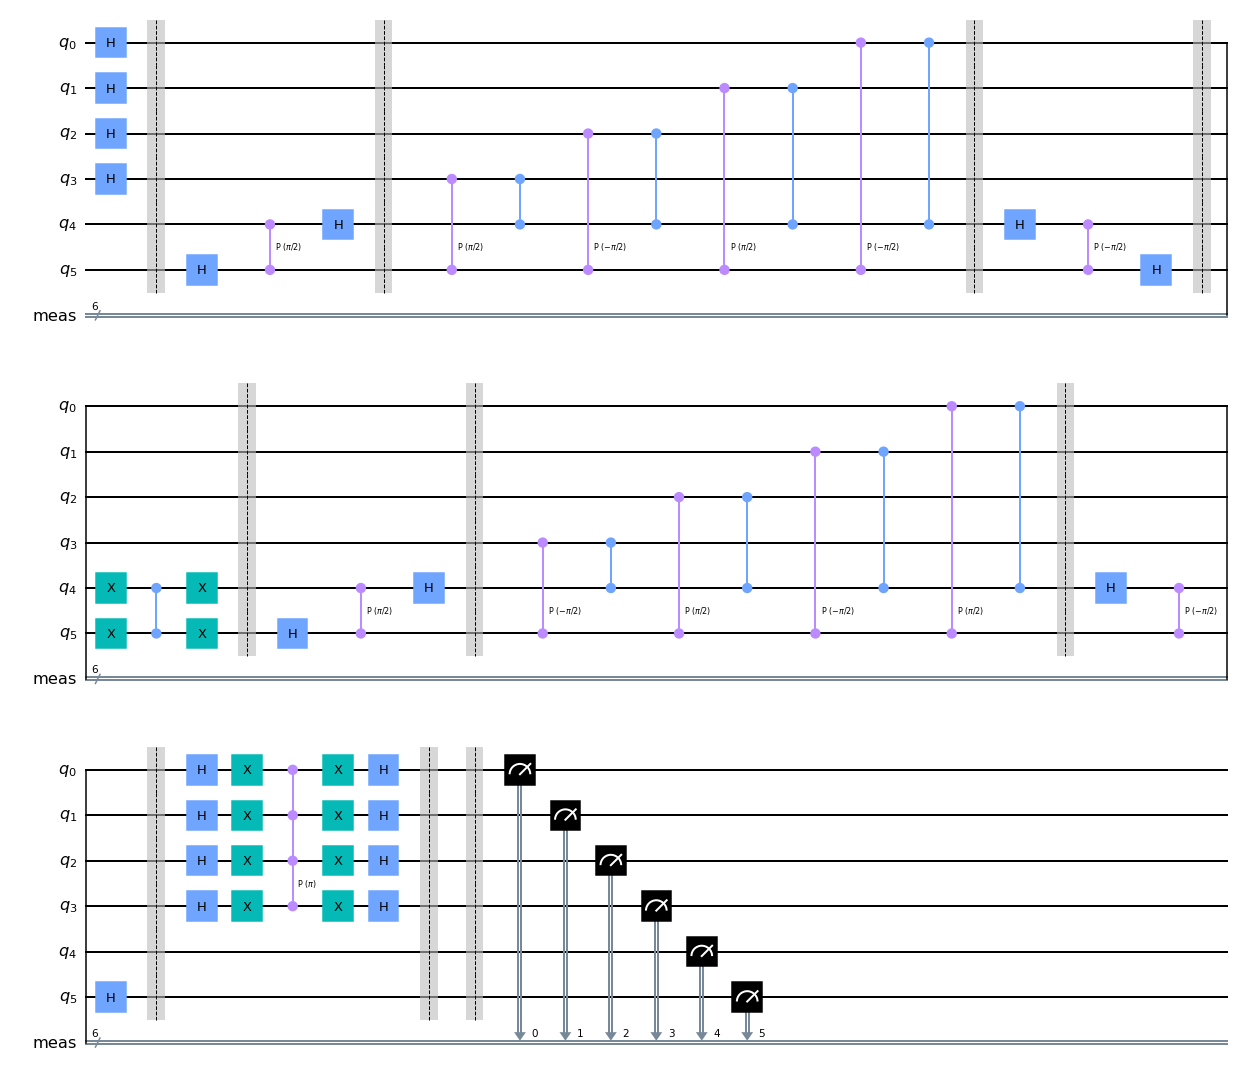

In [11]:
fizz = QuantumCircuit(6)
init(fizz)
qft(fizz)
div_by_3(fizz)
iqft(fizz)
oracle(fizz)
qft(fizz)
inv_div_by_3(fizz)
iqft(fizz)
diffuser(fizz)
fizz.measure_all()
fizz.draw()

Send the circuit to device for executing. Here we get a main simulator of the Aer provider as a backend. It mimics a behavior of real quantum hardware systems those may not be available to everyone. By default the simulator is noise-free what is useful for education or debugging. We are also possible to run the circuits on real quantum devices however an error correction may be required.

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


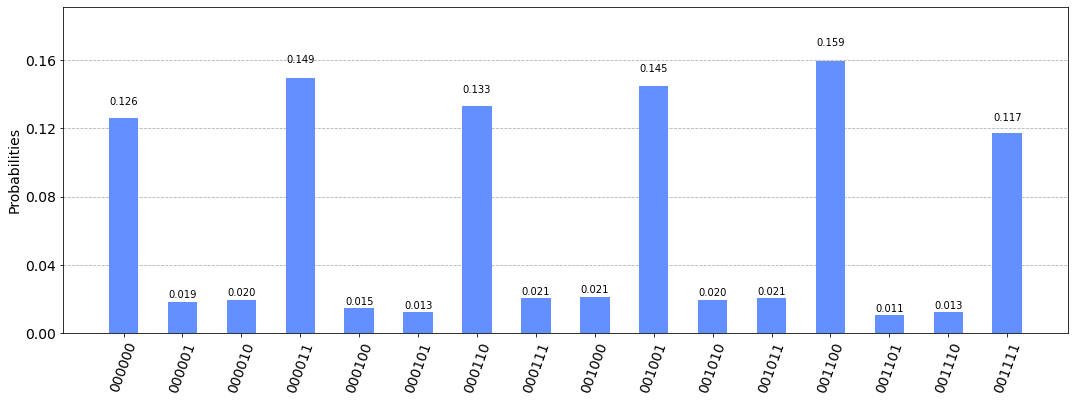

In [12]:
simulator = Aer.get_backend('aer_simulator')
job_fizz = execute(fizz, simulator, shots = 1024)
result_fizz = job_fizz.result()
counts_fizz = result_fizz.get_counts()
plot_histogram(counts_fizz, figsize = (18, 6))

## Buzz

Now exactly the same way create and then execute another one quantum circuit to find multiples of $5$.

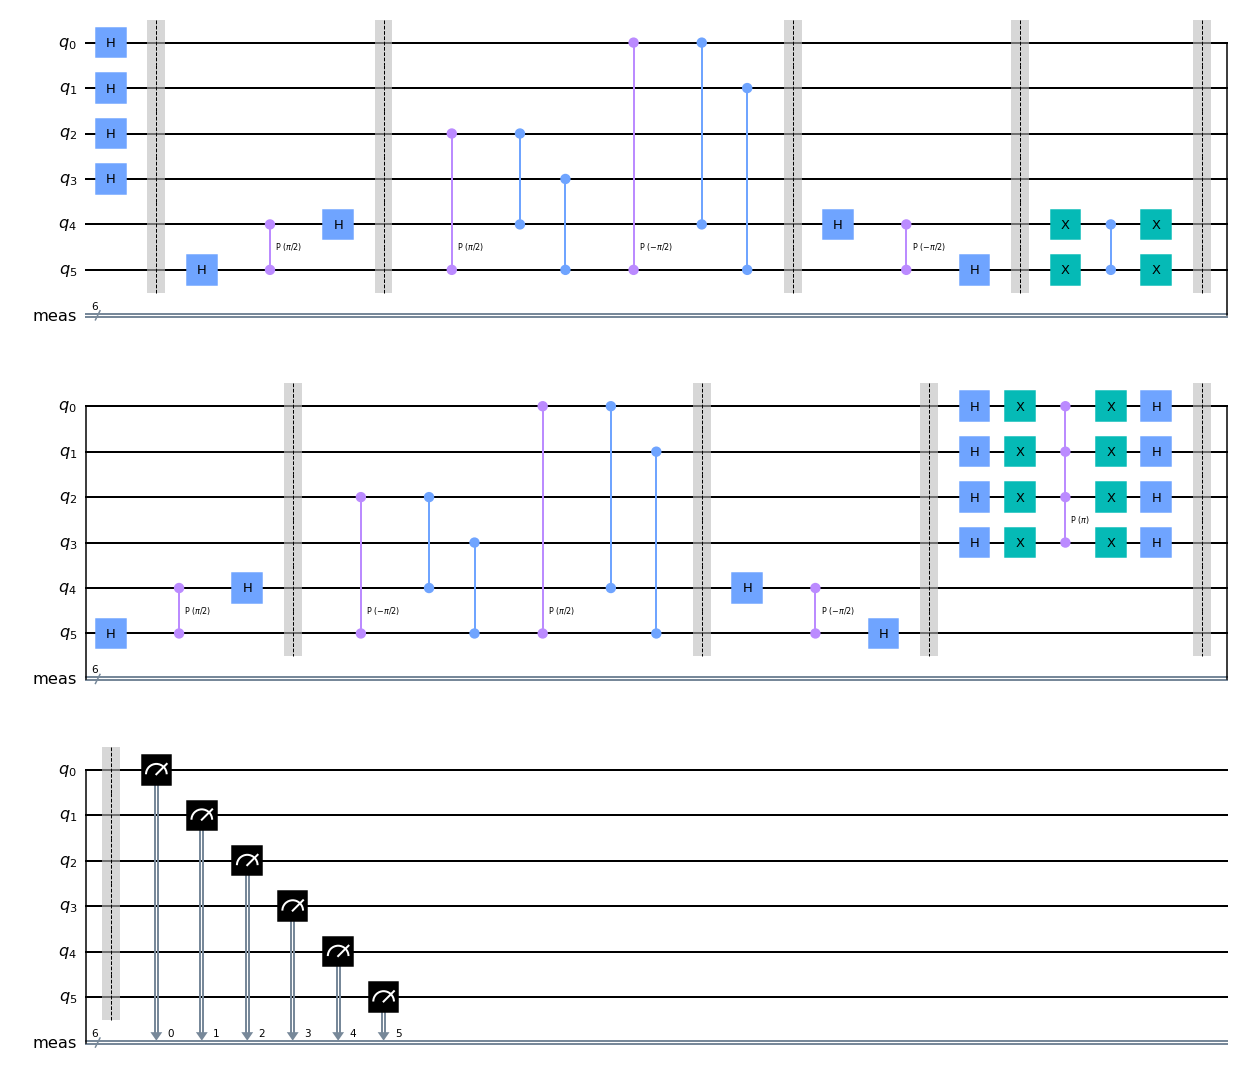

In [13]:
buzz = QuantumCircuit(6)
init(buzz)
qft(buzz)
div_by_5(buzz)
iqft(buzz)
oracle(buzz)
qft(buzz)
inv_div_by_5(buzz)
iqft(buzz)
diffuser(buzz)
buzz.measure_all()
buzz.draw()

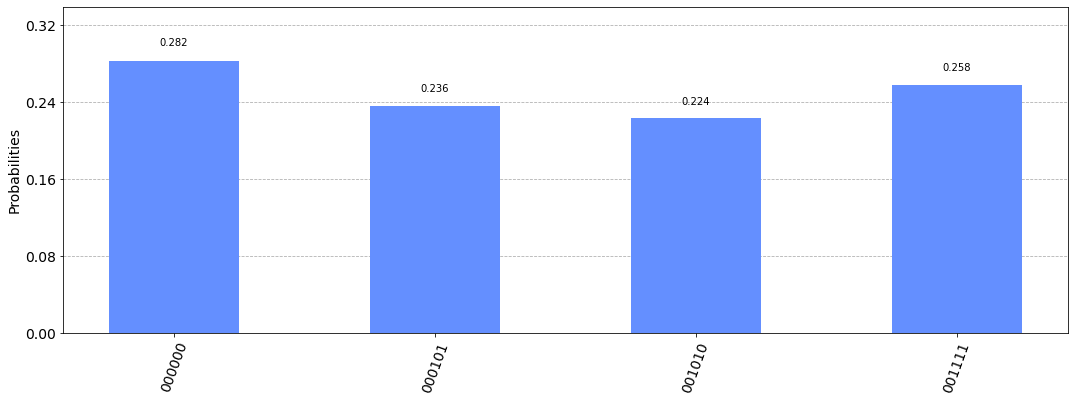

In [14]:
job_buzz = execute(buzz, simulator, shots = 1024)
result_buzz = job_buzz.result()
counts_buzz = result_buzz.get_counts()
plot_histogram(counts_buzz, figsize = (18, 6))

## Ouptut

Both circuits running lead to obtain two dictionaries plotted above as histograms. Each high bar corresponds to some binary string with required number in four LSBs (main register). This is an expected result because the strings describe good states amplified by GSA. They are obviously distinguish from others but it is only raw data.

The output we work on is a list of strings so create some pattern for the beginning. Then append firstly *Fizz* and secondly *Buzz* results to elements those indices are decoded from the main register of amplified strings. Other strings are still empty should be filled out their indices directly. Now the FizzBuzz chain is ready!

In [15]:
output = [''] * 16
for key in {k:v for (k,v) in counts_fizz.items() if v>50}:
    output[int(key[2:], 2)] += 'Fizz'
for key in {k:v for (k,v) in counts_buzz.items() if v>50}:
    output[int(key[2:], 2)] += 'Buzz'
for i in range(16):
    if output[i] == '':
        output[i] += str(i)
for out in output:
    print(out, end = '   ')

FizzBuzz   1   2   Fizz   4   Buzz   Fizz   7   8   Fizz   Buzz   11   Fizz   13   14   FizzBuzz   